<a href="https://colab.research.google.com/github/FlorianShepherd/ml/blob/main/nlp_beginner_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
files.upload()


In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 61.8MB/s]


In [5]:
!mkdir Dataset
!cp /content/nlp-getting-started.zip /content/Dataset/nlp-getting-started.zip
!unzip -q /content/Dataset/nlp-getting-started.zip -d /content/Dataset
!rm /content/Dataset/nlp-getting-started.zip


In [6]:
! pip install --upgrade pip
! pip install --no-cache-dir transformers
! pip install sentencepiece
! pip install accelerate
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 238.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 242.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 382.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00


In [7]:
train_df = pd.read_csv("/content/Dataset/train.csv")
test_df = pd.read_csv("/content/Dataset/test.csv")

<Axes: xlabel='keyword,target'>

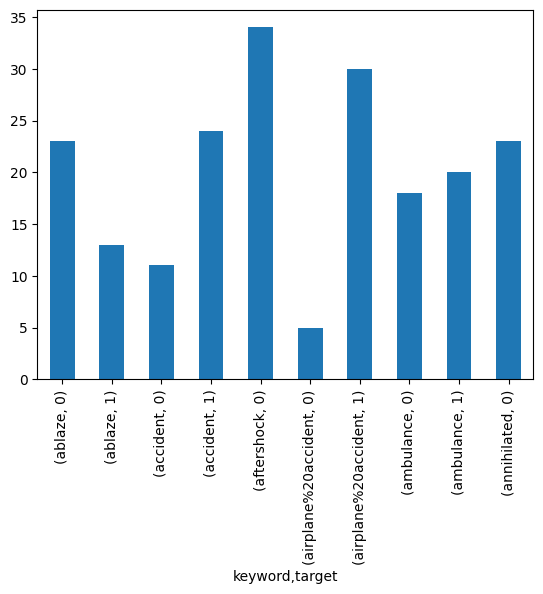

In [8]:
target_group = train_df.groupby(["keyword", "target"]).count()
target_group["text"].iloc[:10].plot.bar(stacked=True)

In [9]:
# data set is very imbalanced within categories, but not imbalanced in the overall distribution (roughly 50:50 in 0:1 targets)
target_group

id  location  text
keyword    target                    
ablaze     0       23        17    23
           1       13        12    13
accident   0       11         7    11
           1       24        21    24
aftershock 0       34        25    34
...                ..       ...   ...
wreck      0       30        23    30
           1        7         4     7
wreckage   1       39        28    39
wrecked    0       36        20    36
           1        3         2     3

[438 rows x 3 columns]

In [10]:
# how many keywords are nan? -> 0.8% - just drop them?
train_df[train_df.keyword.isna()].count() / train_df[~train_df.keyword.isna()].count() * 100.

# drop them
train_df = train_df[~train_df.keyword.isna()]

In [11]:
# how many keywords are nan? Sample text
# train_df[train_df.keyword.isna()].iloc[60]["text"]

In [12]:
# very similar strings ("Obama bla") and also only one sample without being target == 1 -> Ideas: Remove http://t.co ends and then remove duplicates? Also even out samples per keyword
train_df[train_df["keyword"] == "aftershock"]

,id,keyword,location,text,target
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
103,149,aftershock,304,'The man who can drive himself further once th...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0
105,153,aftershock,304,'There is no victory at bargain basement price...,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
107,157,aftershock,304,'Nobody remembers who came in second.' Charles...,0
108,158,aftershock,Instagram - @heyimginog,@afterShock_DeLo im speaking from someone that...,0
109,159,aftershock,304,'The harder the conflict the more glorious the...,0
110,160,aftershock,NaN,#GrowingUpSpoiled going clay pigeon shooting a...,0
111,161,aftershock,Somewhere Only We Know ?,So i guess no one actually wants any free Afte...,0


<Axes: xlabel='keyword,target'>

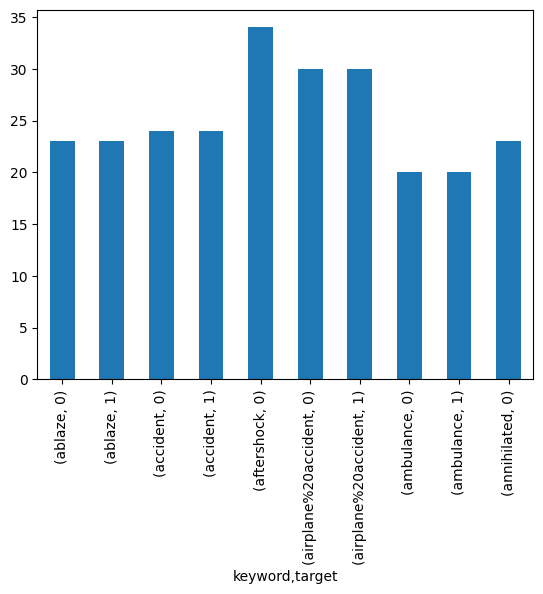

In [13]:
result_df = list()

for keyword, subdf in train_df.groupby("keyword"):
  ones = subdf["target"].sum()
  zeros = len(subdf) - ones

  if ones == 0 or zeros == 0:
    # print(f"For the keyword {keyword} - we have {ones} ones and {zeros} zeros")
    result_df.append(subdf)
    continue

  df_zero = subdf[subdf.target == 0.]
  df_one = subdf[subdf.target == 1.]

  if ones > zeros:
    # duplicates zeros
    n_times = np.floor(len(df_one) / len(df_zero))
    n_rand = len(df_one) % len(df_zero)

    result_df.append(df_zero.loc[df_zero.index.repeat(n_times)])
    result_df.append(df_zero.loc[np.random.choice(df_zero.index, n_rand)])
    result_df.append(df_one)

  elif zeros > ones:
    # duplicates ones
    n_times = np.floor(len(df_zero) / len(df_one))
    n_rand = len(df_zero) % len(df_one)

    result_df.append(df_one.loc[df_one.index.repeat(n_times)])
    result_df.append(df_one.loc[np.random.choice(df_one.index, n_rand)])
    result_df.append(df_zero)

  else:
    # equal - append subdf
    result_df.append(subdf)


result_df = pd.concat(result_df)

train_df = result_df

# all bars should be equal now except the ones where we only have one category
target_group = result_df.groupby(["keyword", "target"]).count()
target_group["text"].iloc[:10].plot.bar(stacked=True)

In [14]:
np.random.choice(train_df.iloc[:10].index, 12)
np.floor(26/10)
subdf.loc[subdf.index.repeat(3)]

,id,keyword,location,text,target
7544,10785,wrecked,"Brooklyn, NY",Wrecked an hour on YouTube with @julian_lage @...,0
7544,10785,wrecked,"Brooklyn, NY",Wrecked an hour on YouTube with @julian_lage @...,0
7544,10785,wrecked,"Brooklyn, NY",Wrecked an hour on YouTube with @julian_lage @...,0
7545,10786,wrecked,Robin Hood's County,late night mcdonalds with friends = hilarious ...,0
7545,10786,wrecked,Robin Hood's County,late night mcdonalds with friends = hilarious ...,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0


In [15]:
train_df["target"] = train_df["target"].astype(float)

mode = train_df.mode().iloc[0]
train_df.fillna(mode, inplace=True)
train_df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [16]:
train_df.iloc[3]

id                                                         56
keyword                                                ablaze
location                                                  USA
text        Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
target                                                    1.0
Name: 38, dtype: object

In [17]:
train_df["input"] = "TEXT1: " + train_df["keyword"] + "; TEXT3: " + train_df["text"]
# train_df["input"] = "TEXT2: " + train_df["location"] + "; TEXT3: " + train_df["text"]

In [18]:
train_df["text"]

31      @bbcmtd Wholesale Markets ablaze http://t.co/l...
33      #AFRICANBAZE: Breaking news:Nigeria flag set a...
37      INEC Office in Abia Set Ablaze - http://t.co/3...
38      Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
46      How the West was burned: Thousands of wildfire...
                              ...                        
7578     @jt_ruff23 @cameronhacker and I wrecked you both
7579    Three days off from work and they've pretty mu...
7580    #FX #forex #trading Cramer: Iger's 3 words tha...
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
Name: text, Length: 11117, dtype: object

In [19]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
model_nm = 'microsoft/deberta-v3-small'
# model_nm = 'microsoft/DeBERTa-v3-base'
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
tokz.tokenize(train_df.iloc[0]["input"])

['▁TEXT',
 '1',
 ':',
 '▁ablaze',
 ';',
 '▁TEXT',
 '3',
 ':',
 '▁@',
 'bbc',
 'm',
 't',
 'd',
 '▁Wholesale',
 '▁Markets',
 '▁ablaze',
 '▁http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'l',
 'HY',
 'X',
 'EO',
 'HY',
 '6',
 'C']

In [21]:
def tok_func(x): return tokz(x["input"])

In [22]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(train_df)

In [23]:
ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input', '__index_level_0__'],
    num_rows: 11117
})

In [24]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/11117 [00:00<?, ? examples/s]

In [25]:
tok_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11117
})

In [26]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: ablaze; TEXT3: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 [1,
  54453,
  435,
  294,
  56599,
  346,
  54453,
  508,
  294,
  1944,
  83520,
  358,
  297,
  407,
  12137,
  12780,
  56599,
  1871,
  294,
  320,
  320,
  297,
  260,
  1902,
  320,
  1406,
  41826,
  2087,
  29215,
  41826,
  765,
  711,
  2])

In [27]:
tok_ds = tok_ds.rename_columns({'target':'labels'})

In [28]:
dds = tok_ds.train_test_split(0.25, seed=1337)

In [29]:
mode = test_df.mode().iloc[0]
test_df.fillna(mode, inplace=True)
test_df.isna().sum()

test_df["input"] = "TEXT1: " + test_df["keyword"] + "; TEXT2: " + test_df["location"] + "; TEXT3: " + test_df["text"]
# test_df["input"] = "TEXT2: " + test_df["location"] + "; TEXT3: " + test_df["text"]


eval_ds = Dataset.from_pandas(test_df).map(tok_func, batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [30]:
eval_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [31]:
def mse(x,y): return np.mean((x-y)**2)
def mse_d(eval_pred): return {'mse': mse(*eval_pred)}

def acc(x,y): return np.mean(1.0-np.abs(np.round(x)-np.round(y)))
def acc_d(eval_pred): return {'acc': acc(*eval_pred)}

acc(0, 1)

0.0

In [32]:
from transformers import TrainingArguments,Trainer


In [33]:
bs = 128
epochs = 5
lr = 8e-5
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=acc_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [34]:
trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Acc
1,No log,0.163710,0.767626
2,No log,0.123942,0.841367
3,No log,0.099482,0.893165
4,No log,0.093637,0.899640
5,No log,0.094367,0.894604


In [35]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds[preds>=0.5] = 1.
preds[preds<0.5] = 0.

In [36]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'target': preds.astype(int).T[0].tolist()
})

submission.to_csv('submission.csv', index=False)


Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

22746

In [37]:
preds.astype(int).T[0].tolist()[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [38]:
dds["test"]["labels"][:10]

[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [39]:
preds = trainer.predict(dds["test"]).predictions.astype(float)
preds[preds>=0.5] = 1.
preds[preds<0.5] = 0.
preds[10:20]

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])